<a href="https://colab.research.google.com/github/szymonczaja/Home-credit-default-risk/blob/main/Home_deafult_credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to predict the **credit risk** of a client based on their banking history.

My **initial hypothesis** is that the biggest impact on the risk assessment will come from:
* **Client's income.**
* **Credit history** (specifically, whether the client paid previous debts on time).
* **Active loans** (whether the client is currently paying off another loan).
* **Credit score.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import optuna
import shap
import mlflow
from optuna.integration.mlflow import MLflowCallback

In [4]:
import pandas as pd
import zipfile
from pathlib import Path
import gdown 

def load_credit_data(file_id, data_dir="datasets"):
    zip_path = Path(data_dir) / "home_credit.zip"
    
    if not zip_path.exists():
        zip_path.parent.mkdir(parents=True, exist_ok=True)
        gdown.download(f'https://drive.google.com/uc?id={file_id}', str(zip_path), quiet=False)
        
    print("Wczytywanie danych z ZIP...")
    with zipfile.ZipFile(zip_path) as z:
        return {
            Path(f).stem: pd.read_csv(z.open(f), encoding='cp1252') 
            for f in z.namelist() 
            if f.endswith('.csv') and 'sample_submission' not in f
        }

FILE_ID = '19QSrABktOfzot_la8x7oxbOvUW8LooiW' 
data = load_credit_data(FILE_ID)

Wczytywanie danych z ZIP...


In [5]:
X_train = data['application_train']
test_data_kaggle = data['application_test']


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
X_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
corr = X_train.select_dtypes(include=np.number).corr()['TARGET'].sort_values()
print(f'Najsilniejsze negatywne korelacje: {corr.head(15)}')
print(f'Najsiliejsze pozytywne korelacje: {corr.tail(15)}')

Najsilniejsze negatywne korelacje: EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
FLOORSMIN_MEDI               -0.033394
LIVINGAREA_AVG               -0.032997
LIVINGAREA_MEDI              -0.032739
Name: TARGET, dtype: float64
Najsiliejsze pozytywne korelacje: DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.0459

### Correlation Analysis & Key Insights

The correlation matrix reveals several important relationships between features and the target variable (Default Risk):

1.  **Strongest Negative Correlations (Safe Indicators):**
    * **`EXT_SOURCE_1/2/3`**: These features show the strongest negative correlation (~ -0.16 to -0.17).
    * *Interpretation:* Higher values of external scoring correspond to a **lower probability of default**. These are the most powerful predictors in the dataset.

2.  **Positive Correlations (Risk Indicators):**
    * **`DAYS_BIRTH` (+0.078)**: This shows a positive correlation.
    * *Note on Interpretation:* Since age is stored as negative days (e.g., -15000), a "higher" value (closer to 0) means a **younger** person. Therefore, **younger clients tend to be riskier**, while older clients are more likely to repay.
    * **`REGION_RATING_CLIENT`**: Higher regional ratings (likely indicating poorer regions) correlate with higher default risk.

3.  **Overall Conclusion:**
    * There are no extremely strong linear correlations (max ~0.18).
    * This confirms that linear models (like Logistic Regression) might underperform compared to **non-linear models** like **XGBoost** or **LightGBM**, which can capture complex, non-linear interactions between these features.

In [10]:
X_train.shape

(307511, 122)

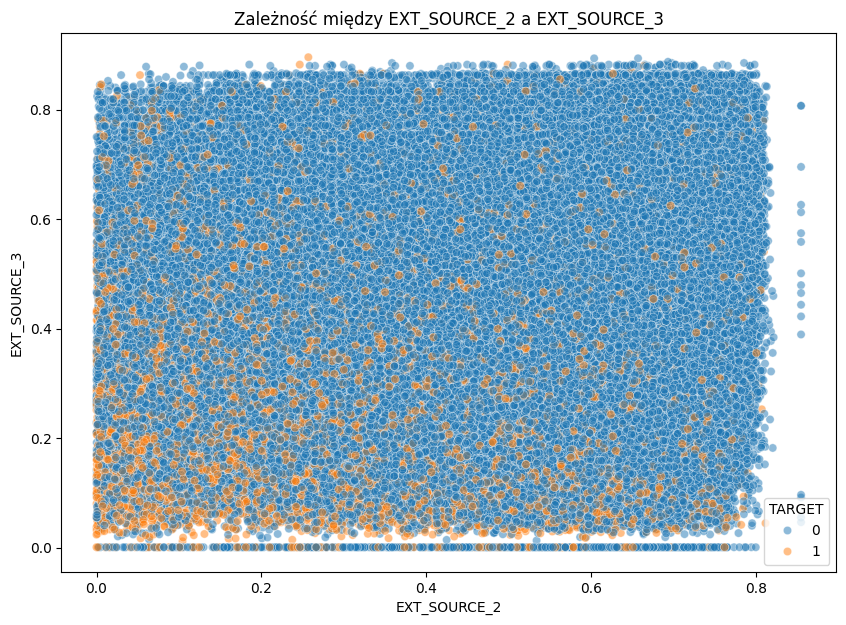

In [11]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='EXT_SOURCE_2', y='EXT_SOURCE_3', hue='TARGET', data=X_train, alpha=0.5)
plt.title('Zależność między EXT_SOURCE_2 a EXT_SOURCE_3')
plt.show()


This plot visualizes the interaction between `EXT_SOURCE` features, which represent credit scores from external agencies.

**Observations:**
* **High Risk Cluster:** Clients with `TARGET = 1` (Orange points / Defaulters) are clearly clustered in the **lower-left corner**.
* **Interpretation:** This confirms that **low values** of external scores correspond to a **high risk** of default.
* **Separability:** The clear distinction between the orange and blue clusters explains why `EXT_SOURCE` features are the strongest predictors in our model.

In [12]:
(X_train['DAYS_EMPLOYED'] > 350000).value_counts()

DAYS_EMPLOYED
False    252137
True      55374
Name: count, dtype: int64

In [4]:
X_train['DAYS_EMPLOYED_ANOM'] = (X_train['DAYS_EMPLOYED'] > 350000)
print(X_train.groupby(['DAYS_EMPLOYED_ANOM'])['TARGET'].mean())

DAYS_EMPLOYED_ANOM
False    0.086600
True     0.053996
Name: TARGET, dtype: float64


Wśród osób z anomalią odsetek osób z problemami ze spłatą zoobowiązań wobec banku jest niski.

In [5]:

X_train.loc[X_train['DAYS_EMPLOYED'] > 350000, 'DAYS_EMPLOYED'] = np.nan

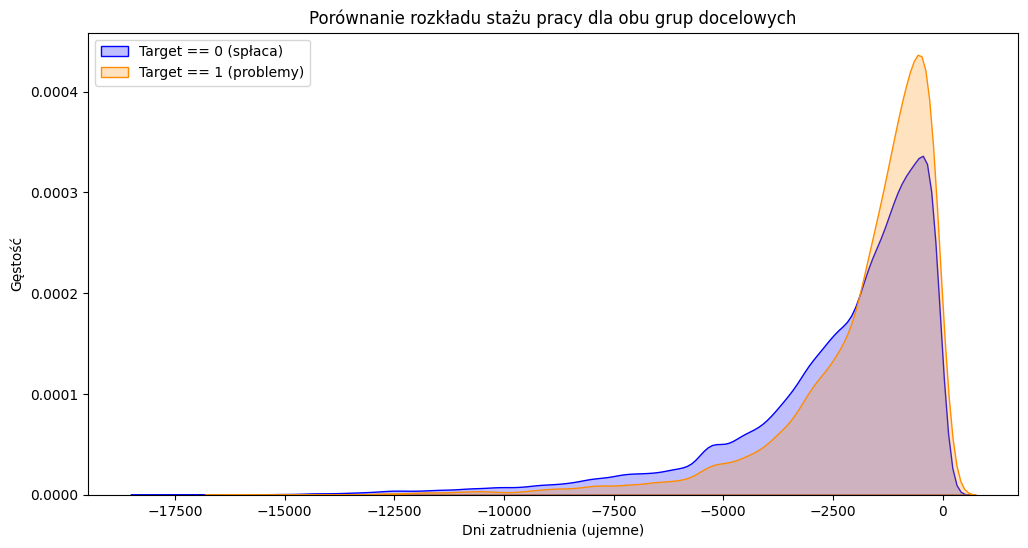

In [15]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_EMPLOYED'],
            label='Target == 0 (spłaca)',
            color='blue', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_EMPLOYED'],
            label='Target == 1 (problemy)',
            color='darkorange', fill=True)

plt.xlabel('Dni zatrudnienia (ujemne)')
plt.ylabel('Gęstość')
plt.title('Porównanie rozkładu stażu pracy dla obu grup docelowych')
plt.legend()
plt.show()


**Observations:**
* **Distinct Separation:** There is a visible shift between the two distributions. The peak for Defaulters (Target=1) is located at values closer to 0.
* **Interpretation:** Since `DAYS_EMPLOYED` values are negative (days before application), values closer to 0 indicate **shorter employment history**.
* **Conclusion:** **Shorter employment duration is strongly correlated with higher default risk.** This confirms that job stability is a key indicator of a client's financial reliability.

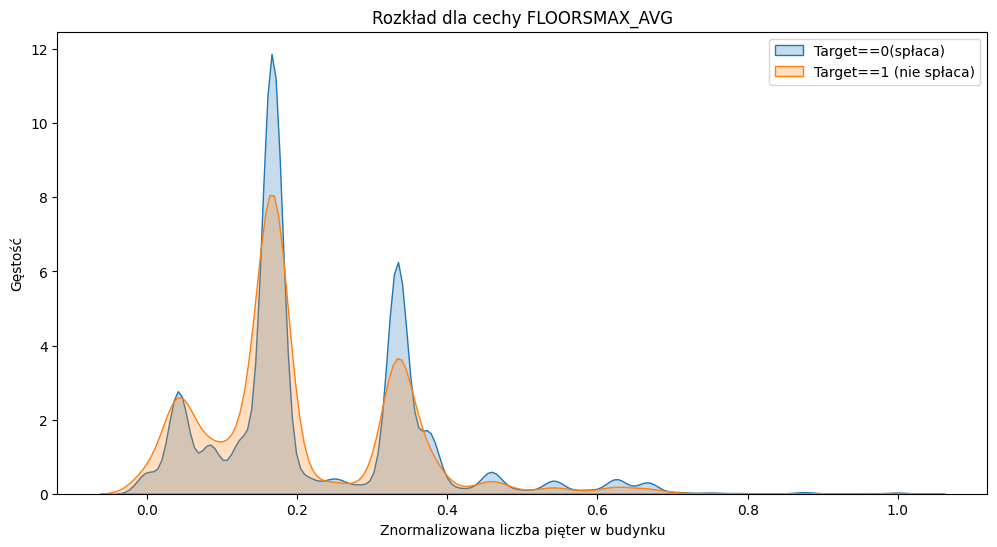

In [16]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'FLOORSMAX_AVG'],
            label='Target==0(spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET']==1, 'FLOORSMAX_AVG'],
            label='Target==1 (nie spłaca)', fill=True)
plt.title('Rozkład dla cechy FLOORSMAX_AVG')
plt.xlabel('Znormalizowana liczba pięter w budynku')
plt.ylabel('Gęstość')
plt.legend()
plt.show()


**Observations:**
* **High Overlap:** The blue (Target=0) and orange (Target=1) density curves overlap almost completely.
* **Interpretation:** There is no significant difference in the distribution of `FLOORSMAX_AVG` between reliable clients and defaulters. This suggests that the number of floors in a building is **not** a discriminatory factor for credit risk.
* **Validation:** This visual analysis confirms the **very low correlation** score observed earlier. This feature, on its own, has negligible predictive power.

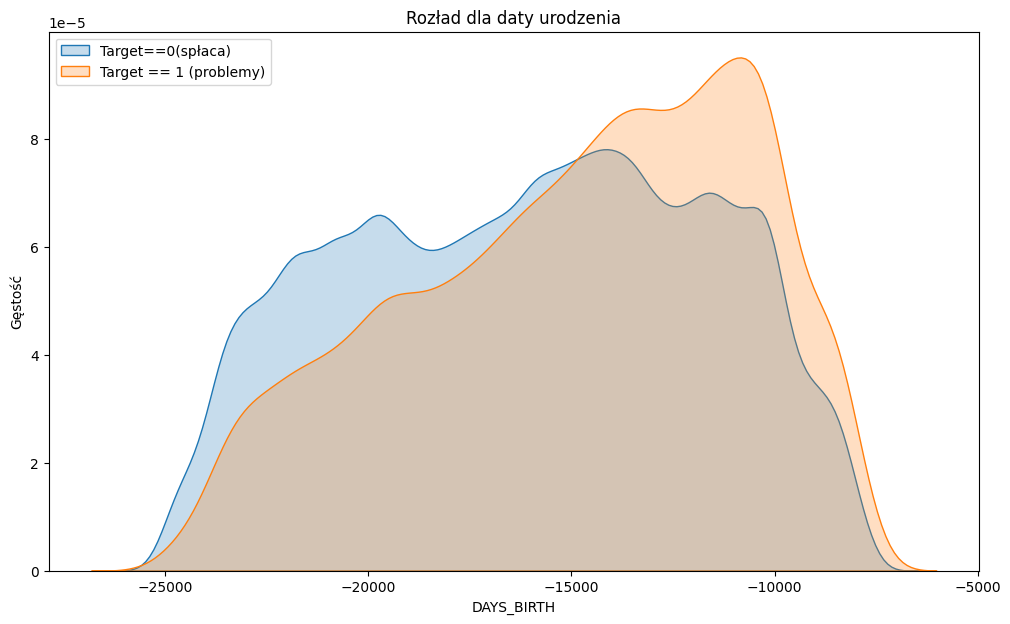

In [ ]:
plt.figure(figsize=(12, 7))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_BIRTH'],
            label='Target==0(spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET']==1, 'DAYS_BIRTH'],
            label='Target == 1 (problemy)', fill=True)

plt.title('Rozład dla daty urodzenia')
plt.xlabel('DAYS_BIRTH')
plt.ylabel('Gęstość')
plt.legend()
plt.show()



The visualization of client age reveals a significant demographic trend:

* **Distribution Shift:** The orange distribution (Target = 1 / Defaulters) is clearly shifted to the **left**, indicating a lower average age.
* **Key Insight:** Clients who fail to repay their loans are **statistically younger**. Conversely, reliable clients tend to be older.
* **Conclusion:** Younger age is associated with **higher credit risk**, making it a strong predictive feature for the model.

In [18]:
X_train['REGION_RATING_CLIENT_W_CITY'].value_counts()

REGION_RATING_CLIENT_W_CITY
2    229484
3     43860
1     34167
Name: count, dtype: int64

In [19]:
region_probs = X_train.groupby('REGION_RATING_CLIENT_W_CITY')['TARGET'].mean()

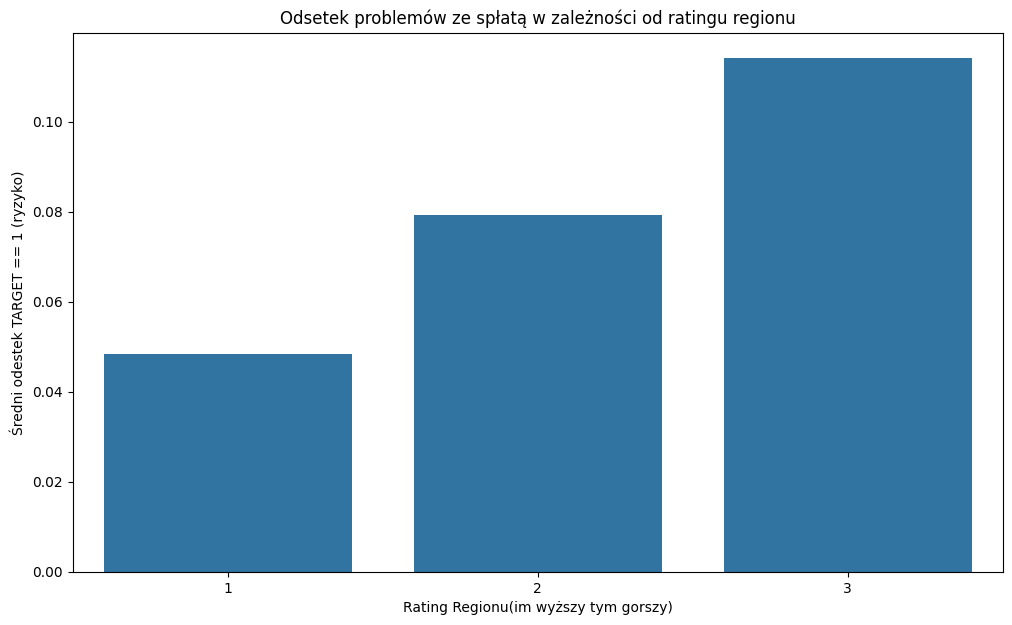

In [20]:
plt.figure(figsize=(12, 7))
sns.barplot(x=region_probs.index, y=region_probs.values)
plt.title('Odsetek problemów ze spłatą w zależności od ratingu regionu')
plt.xlabel('Rating Regionu(im wyższy tym gorszy)')
plt.ylabel('Średni odestek TARGET == 1 (ryzyko)')
plt.show()



**Observations:**
* **Clear Trend:** There is a strong positive correlation between the Region Rating and the default rate. As the rating "worsens" (higher numerical value), the percentage of defaults increases significantly.
* **Interpretation:** Clients residing in lower-rated regions (likely characterized by lower economic stability or higher unemployment) pose a **higher credit risk**.
* **Conclusion:** This feature acts as a powerful **socio-economic proxy**, making it a strong predictor for the model.

In [21]:
X_train['DAYS_LAST_PHONE_CHANGE'].value_counts()

DAYS_LAST_PHONE_CHANGE
 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-3905.0        1
-3752.0        1
-3866.0        1
-3861.0        1
-3755.0        1
Name: count, Length: 3773, dtype: int64

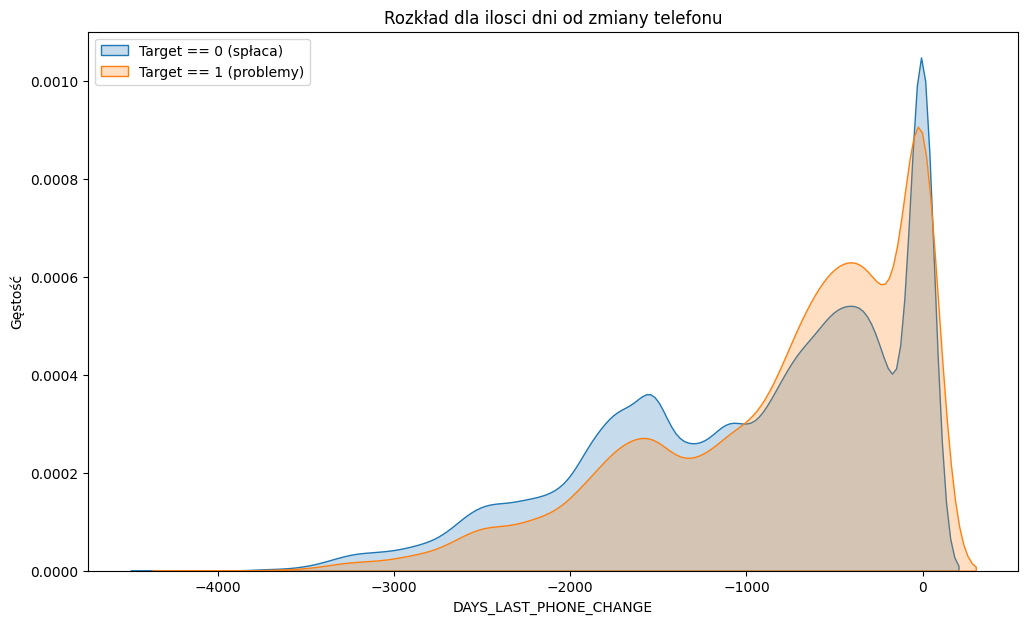

In [22]:
plt.figure(figsize=(12, 7))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_LAST_PHONE_CHANGE'],
            label='Target == 0 (spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_LAST_PHONE_CHANGE'],
            label='Target == 1 (problemy)', fill=True)

plt.title('Rozkład dla ilosci dni od zmiany telefonu')
plt.xlabel('DAYS_LAST_PHONE_CHANGE')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

**Observations:**
* **Identical Distributions:** The density plots for both classes (Target=0 and Target=1) overlap almost completely.
* **Interpretation:** There is no visible difference in the distribution of this feature between clients with payment difficulties and those without.
* **Conclusion:** This feature appears to have **negligible predictive power** regarding default risk in a univariate analysis.

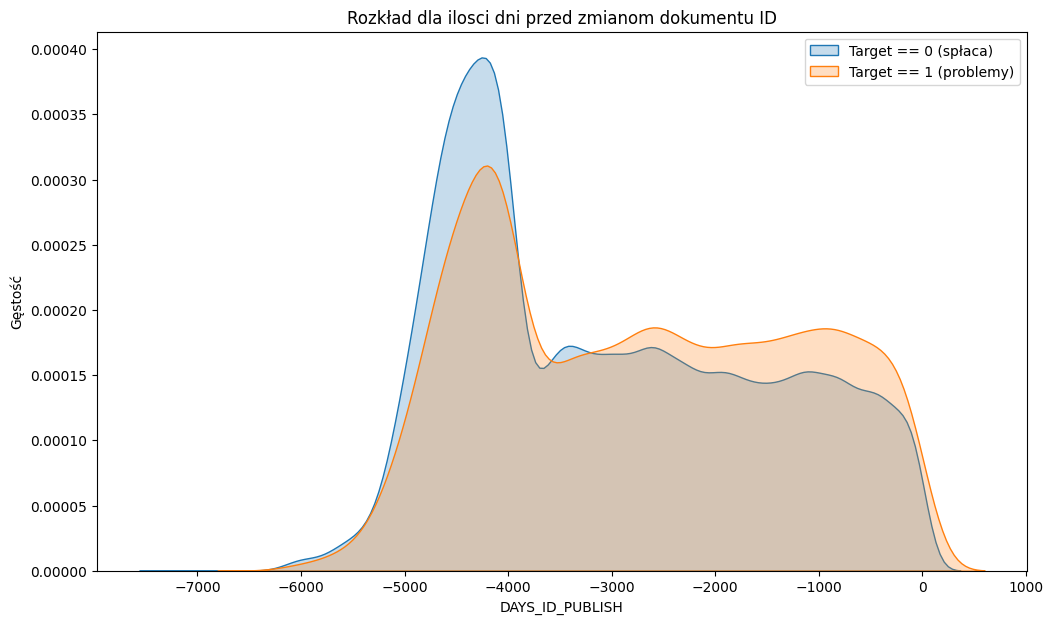

In [23]:
plt.figure(figsize=(12, 7))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_ID_PUBLISH'],
            label='Target == 0 (spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_ID_PUBLISH'],
            label='Target == 1 (problemy)', fill=True)

plt.title('Rozkład dla ilosci dni przed zmianom dokumentu ID')
plt.xlabel('DAYS_ID_PUBLISH')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

**Observations:**
* **High Overlap:** The distributions for both classes (Target=0 and Target=1) are nearly identical across the entire range.
* **Interpretation:** The number of days since the client changed their ID document does not appear to be a strong indicator of credit risk on its own.
* **Conclusion:** This feature shows **low discriminatory power** in univariate analysis, suggesting that the age of the identity document is not a primary driver of default risk.

In [24]:
bureau = data['bureau']

In [25]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [27]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


Kolumna SK_ID_CURR łączy bureau z application_train/test

In [28]:
bureau['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64

Kolumna do potencjalnego one hot encodingu

In [29]:
bureau['CREDIT_CURRENCY'].value_counts()

CREDIT_CURRENCY
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: count, dtype: int64

tak samo pojdzie do OneHotEncoder()

In [30]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_status_counts = bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts(normalize=True).unstack(fill_value=0)
bureau_status_counts.columns = ['BUREAU_STATUS_' + str(col).upper() for col in bureau_status_counts.columns]

bureau_full_agg = bureau_agg.join(bureau_status_counts, how='left', on='SK_ID_CURR')

X_train_with_bureau = X_train.join(bureau_full_agg, how='left', on='SK_ID_CURR')
X_train_with_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_STATUS_ACTIVE,BUREAU_STATUS_BAD DEBT,BUREAU_STATUS_CLOSED,BUREAU_STATUS_SOLD
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-103.0,-874.00,865055.565,108131.945625,0.0,0.0,0.25,0.0,0.75,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-606.0,-1400.75,1017400.500,254350.125000,0.0,0.0,0.25,0.0,0.75,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-408.0,-867.00,189037.800,94518.900000,0.0,0.0,0.00,0.0,1.00,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-1149.0,-1149.00,146250.000,146250.000000,0.0,0.0,0.00,0.0,1.00,0.0


In [31]:
prev_app = data['previous_application']
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
prev_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [33]:
prev_app['APP_CREDIT_RATIO'] = prev_app['AMT_CREDIT'] / prev_app['AMT_APPLICATION']
prev_app['APP_CREDIT_RATIO'] = prev_app['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan)
prev_app['APP_CREDIT_RATIO'] = prev_app['APP_CREDIT_RATIO'].fillna(0)

prev_app_status_pct = prev_app.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts(normalize=True).unstack(fill_value=0)
prev_app_status_pct.columns = ['PREV_APP_STATUS_' + str(col).upper() for col in prev_app_status_pct.columns]

prev_app_num_agg = prev_app.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'APP_CREDIT_RATIO': ['mean', 'max']
})

prev_app_num_agg.columns = ['PREV_APP_' + '_'.join(col).upper() for col in prev_app_num_agg.columns]
prev_app_full_agg = prev_app.join(prev_app_num_agg, how='left', on='SK_ID_CURR')
prev_app_full_agg.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,APP_CREDIT_RATIO,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MAX,PREV_APP_APP_CREDIT_RATIO_MEAN,PREV_APP_APP_CREDIT_RATIO_MAX
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,-42.0,300.0,-42.0,-37.0,0.0,1.00000,641848.500000,1800000.0,1.026818,1.105608
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,-134.0,916.0,365243.0,365243.0,1.0,1.11880,201525.750000,607500.0,0.793122,1.138600
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,-271.0,59.0,365243.0,365243.0,1.0,1.21284,66690.000000,112500.0,0.813033,1.212840
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,-482.0,-152.0,-182.0,-177.0,1.0,1.04620,259704.997826,675000.0,0.943989,1.163700
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,1.19720,179037.720000,675000.0,0.759495,1.287700


In [34]:
installments_pay = data['installments_payments']
installments_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [35]:
installments_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [36]:
installments_pay['PAYMENT_DELAY'] = installments_pay['DAYS_ENTRY_PAYMENT'] - installments_pay['DAYS_INSTALMENT']
installments_pay['PAYMENT_DIFFERENCE'] = installments_pay['AMT_INSTALMENT'] - installments_pay['AMT_PAYMENT']
installments_pay_agg = installments_pay.groupby('SK_ID_CURR').agg({
    'PAYMENT_DELAY': ['mean', 'max', lambda x: (x > 0).sum()],
    'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x>0).sum()]
})

installments_pay_agg.columns = pd.Index([
    'INSTALLMENTS_DELAY_MEAN',
    'INSTALLMENTS_DELAY_MAX',
    'INSTALLMENTS_DELAY_COUNT',
    'INSTALLMENTS_DIFFERENCE_MEAN',
    'INSTALLMENTS_DIFFERENCE_MAX',
    'INSTALLMENTS_DIFFERENCE_COUNT'
])
installments_pays_full_agg = installments_pay.join(installments_pay_agg, how='left', on='SK_ID_CURR')
installments_pays_full_agg.head()


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_DELAY,PAYMENT_DIFFERENCE,INSTALLMENTS_DELAY_MEAN,INSTALLMENTS_DELAY_MAX,INSTALLMENTS_DELAY_COUNT,INSTALLMENTS_DIFFERENCE_MEAN,INSTALLMENTS_DIFFERENCE_MAX,INSTALLMENTS_DIFFERENCE_COUNT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,-7.0,0.000,-10.900990,0.0,0,0.000000,0.000,0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0.0,0.000,-3.056962,9.0,11,787.313165,26067.465,15
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0.0,0.000,5.333333,23.0,1,0.000000,0.000,0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,-8.0,0.000,0.666667,74.0,11,5491.033333,21174.300,14
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,17.0,4.455,-7.800000,17.0,9,622.389000,2389.680,16


In [37]:
credit_card_balance = data['credit_card_balance']
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [38]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [39]:
credit_card_balance['PAYMENT_DIFFERENCE'] = credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance['AMT_PAYMENT_CURRENT']
credit_card_balance['ATM_DRAWNINGS_RATIO'] = credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance['AMT_DRAWINGS_CURRENT']
credit_card_balance['ATM_DRAWNINGS_RATIO'] = credit_card_balance['ATM_DRAWNINGS_RATIO'].replace([np.inf, -np.inf], np.nan)

credit_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
     'AMT_BALANCE': ['mean', 'max'],
     'ATM_DRAWNINGS_RATIO': ['mean', 'max'],
     'SK_DPD': ['mean', 'max', lambda x: (x>0).sum()],
     'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x<0).sum()]
})

credit_agg.columns = pd.Index([
    'AMT_BALANCE_MEAN',
    'AMT_BALANCE_MAX',
    'ATM_DRAWNINGS_RATIO_MEAN',
    'ATM_DRAWNINGS_RATIO_MAX',
    'SK_DPD_MEAN',
    'SK_DPD_MAX',
    'SK_DPD_COUNT',
    'PAYMENT_DIFFERENCE_MEAN',
    'PAYMENT_DIFFERENCE_MAX',
    'PAYMENT_DIFFERENCE_COUNT'
])

credit_card_full_agg = credit_card_balance.join(credit_agg, how='left', on='SK_ID_CURR')
credit_card_full_agg.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_BALANCE_MEAN,AMT_BALANCE_MAX,ATM_DRAWNINGS_RATIO_MEAN,ATM_DRAWNINGS_RATIO_MAX,SK_DPD_MEAN,SK_DPD_MAX,SK_DPD_COUNT,PAYMENT_DIFFERENCE_MEAN,PAYMENT_DIFFERENCE_MAX,PAYMENT_DIFFERENCE_COUNT
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,27973.440000,69186.690,0.142857,1.0,0.127660,6,1,0.000000,0.0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,32895.901875,72964.440,0.893017,1.0,0.010417,1,1,-27.800625,0.0,32
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,112572.811216,273194.640,0.644076,1.0,0.000000,0,0,0.000000,0.0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,189173.943000,237884.130,0.521454,1.0,0.000000,0,0,-160.714286,0.0,1
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,194543.745469,461330.505,0.381398,1.0,0.010417,1,1,-22.435781,0.0,1


In [40]:
credit_card_full_agg['PAYMENT_DIFFERENCE_COUNT'].value_counts()

PAYMENT_DIFFERENCE_COUNT
0      1176950
1       138473
2       114803
3        91127
4        77051
        ...   
91       10338
92        9972
93        9957
94        8523
147        178
Name: count, Length: 98, dtype: int64

In [7]:
class CustomTransformator(TransformerMixin, BaseEstimator):
  def __init__(self, bureau, prev_app, installments_pay, credit_card_balance):
    self.bureau = bureau
    self.prev_app = prev_app
    self.installments_pay = installments_pay
    self.credit_card_balance = credit_card_balance

  def fit(self, X, y=None):
    return self

  def _process_bureau(self, df_input) -> pd.DataFrame:
    df = df_input.copy()
    bureau_agg = self.bureau.groupby('SK_ID_CURR').agg({
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'AMT_CREDIT_SUM': ['sum', 'mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean']
    })
    bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
    bureau_status_counts = self.bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts(normalize=True).unstack(fill_value=0)
    bureau_status_counts.columns = ['BUREAU_STATUS_' + str(col).upper() for col in bureau_status_counts.columns]
    bureau_full_agg = bureau_agg.join(bureau_status_counts, how='left', on='SK_ID_CURR')
    df = df.join(bureau_full_agg, how='left', on='SK_ID_CURR')
    return df

  def _process_application(self, df_input) -> pd.DataFrame:
    df = df_input.copy()
    prev_app_copy = self.prev_app.copy()
    prev_app_copy['APP_CREDIT_RATIO'] = prev_app_copy['AMT_CREDIT'] / prev_app_copy['AMT_APPLICATION']
    prev_app_copy['APP_CREDIT_RATIO'] = prev_app_copy['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan)
    prev_app_copy['APP_CREDIT_RATIO'] =  prev_app_copy['APP_CREDIT_RATIO'].fillna(0)
    prev_app_status_pct = prev_app_copy.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts(normalize=True).unstack(fill_value=0)
    prev_app_status_pct.columns = ['PREV_APP_STATUS_' + str(col).upper() for col in prev_app_status_pct.columns]
    prev_app_num_agg = prev_app_copy.groupby('SK_ID_CURR').agg({
        'AMT_APPLICATION': ['mean', 'max'],
        'APP_CREDIT_RATIO': ['mean', 'max']
    })
    prev_app_num_agg.columns = ['PREV_APP_' + '_'.join(col).upper() for col in prev_app_num_agg.columns]
    prev_app_full_agg = prev_app_status_pct.join(prev_app_num_agg, how='left', on='SK_ID_CURR')
    df = df.join(prev_app_full_agg, how='left', on='SK_ID_CURR')
    return df

  def _process_application_features(self, df_input) -> pd.DataFrame:
    '''
    Przetwarza i tworzy nowe cechy z głównej tabeli application.csv
    '''
    df = df_input.copy()
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] > 350000).astype(int)
    df.loc[df['DAYS_EMPLOYED'] > 350000, 'DAYS_EMPLOYED'] = np.nan
    return df

  def _process_installments(self, df_input):
    df = df_input.copy()
    installments_pay_copy = self.installments_pay.copy()
    installments_pay_copy['PAYMENT_DELAY'] = installments_pay_copy['DAYS_ENTRY_PAYMENT'] - installments_pay_copy['DAYS_INSTALMENT']
    installments_pay_copy['PAYMENT_DIFFERENCE'] = installments_pay_copy['AMT_INSTALMENT'] - installments_pay_copy['AMT_PAYMENT']
    installments_pay_agg = installments_pay_copy.groupby('SK_ID_CURR').agg({
        'PAYMENT_DELAY': ['mean', 'max', lambda x: (x > 0).sum()],
        'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x>0).sum()]
    })
    installments_pay_agg.columns = pd.Index([
        'INSTALLMENTS_DELAY_MEAN',
        'INSTALLMENTS_DELAY_MAX',
        'INSTALLMENTS_DELAY_COUNT',
        'INSTALLMENTS_DIFFERENCE_MEAN',
        'INSTALLMENTS_DIFFERENCE_MAX',
        'INSTALLMENTS_DIFFERENCE_COUNT'
    ])
    df = df.join(installments_pay_agg, how='left', on='SK_ID_CURR')
    return df

  def _process_credit_card(self, df_input) -> pd.DataFrame:
    df = df_input.copy()
    credit_card_balance_copy = self.credit_card_balance.copy()
    credit_card_balance_copy['PAYMENT_DIFFERENCE'] = credit_card_balance_copy['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance_copy['AMT_PAYMENT_CURRENT']
    credit_card_balance_copy['ATM_DRAWNINGS_RATIO'] = credit_card_balance_copy['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance_copy['AMT_DRAWINGS_CURRENT']
    credit_card_balance_copy['ATM_DRAWNINGS_RATIO'] = credit_card_balance_copy['ATM_DRAWNINGS_RATIO'].replace([np.inf, -np.inf], np.nan)

    credit_agg = credit_card_balance_copy.groupby('SK_ID_CURR').agg({
        'AMT_BALANCE': ['mean', 'max'],
        'ATM_DRAWNINGS_RATIO': ['mean', 'max'],
        'SK_DPD': ['mean', 'max', lambda x: (x>0).sum()],
        'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x<0).sum()]
    })

    credit_agg.columns = pd.Index([
        'AMT_BALANCE_MEAN',
        'AMT_BALANCE_MAX',
        'ATM_DRAWNINGS_RATIO_MEAN',
        'ATM_DRAWNINGS_RATIO_MAX',
        'SK_DPD_MEAN',
        'SK_DPD_MAX',
        'SK_DPD_COUNT',
        'PAYMENT_DIFFERENCE_MEAN',
        'PAYMENT_DIFFERENCE_MAX',
        'PAYMENT_DIFFERENCE_COUNT'
    ])
    df = df.join(credit_agg, how='left', on='SK_ID_CURR')
    return df


  def transform(self, X) -> pd.DataFrame:
    df = X.copy()
    df = self._process_bureau(df)
    df = self._process_application(df)
    df = self._process_installments(df)
    df = self._process_credit_card(df)
    df = self._process_application_features(df)
    return df



### Custom Transformer for Advanced Feature Engineering

To handle the complexity of the relational database (multiple tables like `bureau`, `installments_payments`, etc.), I implemented a **Custom Scikit-Learn Transformer** (`CustomTransformator`).

**Key Responsibilities of this Class:**
1.  **Handling One-to-Many Relationships:**
    The main challenge is that one client (`SK_ID_CURR`) has multiple records in auxiliary tables (e.g., 10 previous loans). This transformer aggregates this history into single-row features using statistics like `mean`, `max`, `sum`, and `count`.

2.  **Domain-Specific Feature Creation:**
    * **Bureau History:** Aggregates past credits to assess overall debt exposure.
    * **Payment Behavior:** Calculates `PAYMENT_DELAY` (Days Entry - Days Installment) to catch late payers.
    * **Previous Applications:** Computes approval rates (`APP_CREDIT_RATIO`) to see if the client was previously rejected.

3.  **Pipeline Integration:**
    By inheriting from `TransformerMixin` and `BaseEstimator`, this custom logic fits seamlessly into the **MLflow** and **Sklearn Pipeline**. This ensures that raw data goes in, and model-ready features come out, guaranteeing full reproducibility in production.

In [8]:
feature_transformator = CustomTransformator(
    bureau = data['bureau'],
    prev_app = data['previous_application'],
    installments_pay = data['installments_payments'],
    credit_card_balance = data['credit_card_balance']
)
y = X_train['TARGET'].copy()
X = X_train.drop(columns=['TARGET'], axis=1)
X = feature_transformator.transform(X)

###  Performance Optimization: Feature Pre-computation

**Architectural Decision:**
I explicitly apply the `CustomTransformator` on the entire dataset **before** the Cross-Validation and Optuna hyperparameter tuning loop.

**Justification:**
1.  **Computational Efficiency:** The transformer performs expensive `groupby` and aggregation operations on millions of rows. Including this step inside the Cross-Validation loop would redundantly recalculate the exact same features hundreds of times. I implemented this pre-calculation to drastically reduce the training time.
2.  **No Data Leakage:** All transformations in this step are **row-independent** (grouped strictly by `SK_ID_CURR`). The feature engineering for a specific client depends solely on their own history and is not influenced by other samples. Therefore, my approach introduces **zero data leakage**.

In [46]:
X.isna().mean().sort_values(ascending=False).head(15)

ATM_DRAWNINGS_RATIO_MEAN    0.806069
ATM_DRAWNINGS_RATIO_MAX     0.806069
PAYMENT_DIFFERENCE_MAX      0.801438
PAYMENT_DIFFERENCE_MEAN     0.801438
SK_DPD_MAX                  0.717392
AMT_BALANCE_MEAN            0.717392
AMT_BALANCE_MAX             0.717392
SK_DPD_MEAN                 0.717392
PAYMENT_DIFFERENCE_COUNT    0.717392
SK_DPD_COUNT                0.717392
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
dtype: float64

In [54]:
X_train2 = data['application_train']
feature_transformator = CustomTransformator(
    bureau = data['bureau'],
    prev_app = data['previous_application'],
    installments_pay = data['installments_payments'],
    credit_card_balance = data['credit_card_balance']
)
X_train_raw_transformed = feature_transformator.transform(X_train2)

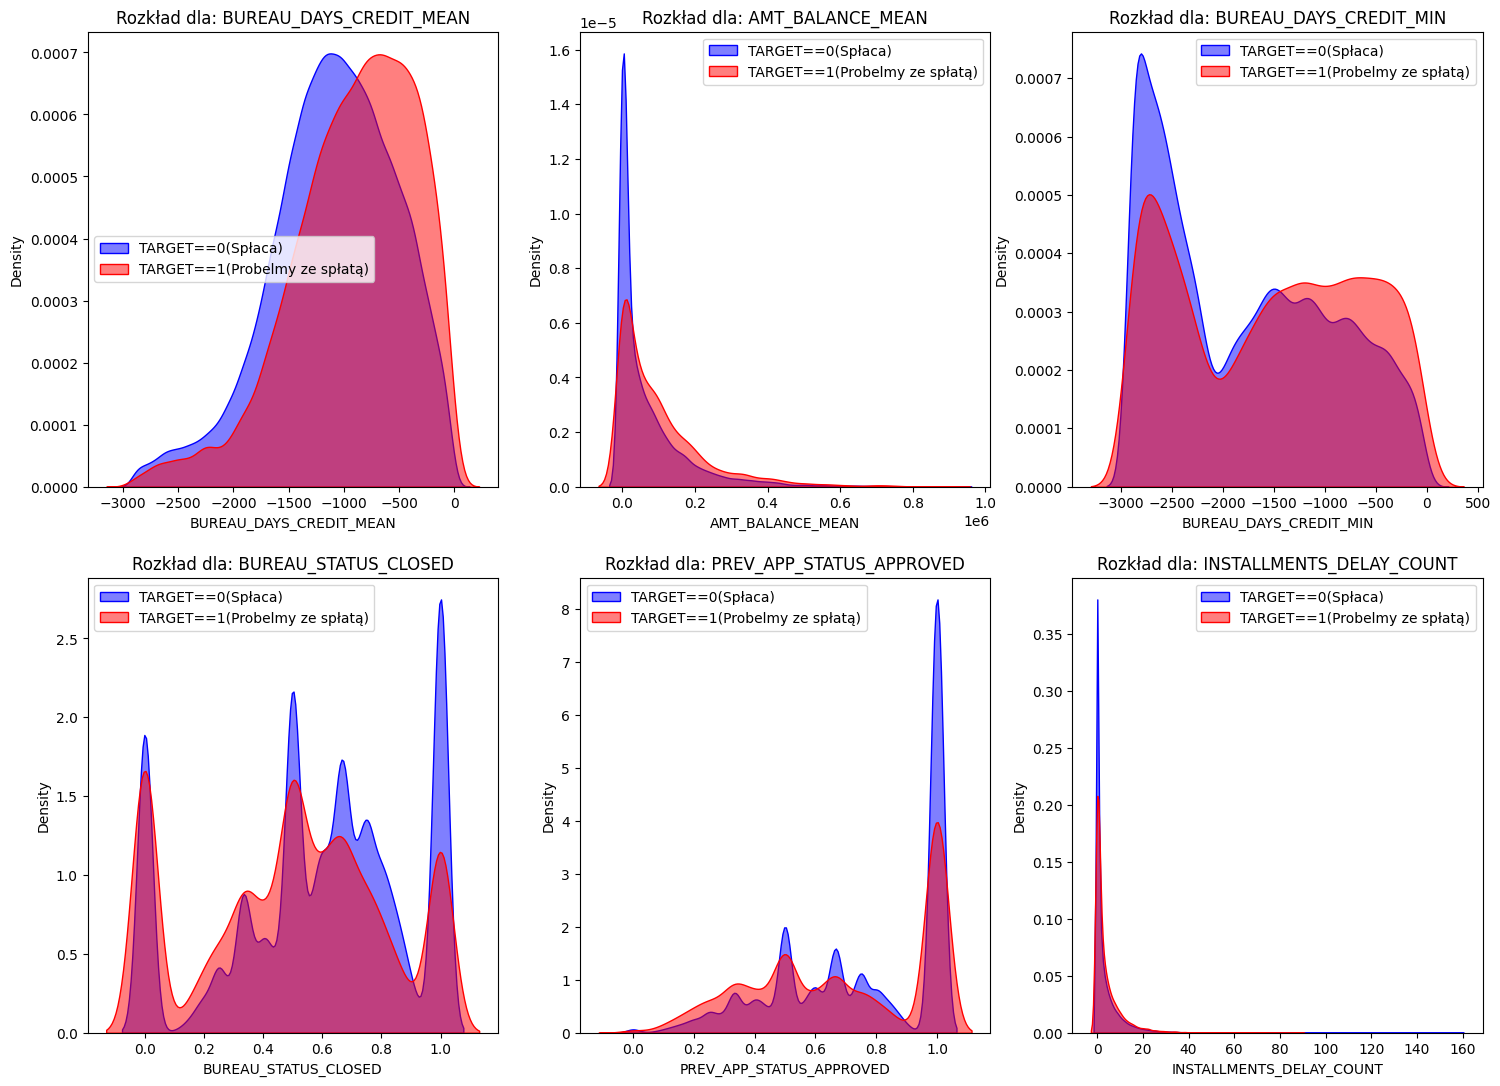

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [55]:
features_to_plot = [
    'BUREAU_DAYS_CREDIT_MEAN',
    'AMT_BALANCE_MEAN',
    'BUREAU_DAYS_CREDIT_MIN',
    'BUREAU_STATUS_CLOSED',
    'PREV_APP_STATUS_APPROVED',
    'INSTALLMENTS_DELAY_COUNT',
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 13))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
  ax = axes[i]
  plt.figure(figsize=(7,5))
  sns.kdeplot(X_train_raw_transformed.loc[X_train_raw_transformed['TARGET']==0, feature].dropna(),
              label='TARGET==0(Spłaca)', fill=True, color='blue', alpha=0.5, ax=ax)
  sns.kdeplot(X_train_raw_transformed.loc[X_train_raw_transformed['TARGET']==1, feature].dropna(),
              label='TARGET==1(Probelmy ze spłatą)', fill=True, color='red', alpha=0.5, ax=ax)
  ax.set_title(f'Rozkład dla: {feature}')
  ax.set_label('')
  ax.legend()
plt.tight_layout()
plt.show()

###  Insight: Recency of Credit Applications

**Observations:**
* **Distribution Shift:** The distributions are similar, but the Defaulters (Target=1) show a slight shift towards zero.
* **Interpretation:** Values closer to zero indicate a shorter time since the last credit application.
* **Conclusion:** Clients who apply for new loans shortly after receiving previous ones ("Credit Hungry" behavior) show a **higher risk of default**. This aligns with the observed correlation.

###  Insight: Credit Card Utilization

**Observations:**
* **Reliable Clients (Blue):** The peak is extremely high near zero, indicating that most reliable clients keep their credit card balances low or pay them off fully.
* **Defaulters (Red - Heavy Tail):** The red curve declines much slower and extends to the right ("Heavy Tail").
* **Conclusion:** There is a much higher probability of finding defaulters among clients with **chronically high credit card balances**. High credit utilization is a strong signal of financial stress.

###  Insight: Length of Credit History

**Observations:**
* **Long History (Blue):** Reliable clients have a higher density at large negative values (e.g., -2000 days), indicating a long-standing relationship with banks.
* **Short History (Red):** The distribution for defaulters peaks closer to zero.
* **Conclusion:** **Short credit history is a risk factor.** Clients with a long track record of borrowing are statistically more likely to repay, whereas "newcomers" to the credit system pose a higher risk.

### Insight: Ratio of Closed Credits

**Observations:**
* **Repayment Discipline:** Reliable clients (Blue) clearly cluster on the right side (high ratio), meaning most of their past loans are successfully closed.
* **Active Burden:** Defaulters (Red) shift towards the left, indicating a higher proportion of **active (open) loans** relative to closed ones.
* **Conclusion:** A history of successfully closing loans is a strong predictor of reliability.

###  Insight: Approval Rate of Previous Applications

**Observations:**
* **Success Rate:** Reliable clients (Blue) have a peak on the right, meaning they received loans for most of their applications.
* **Rejection Signal:** The Defaulter distribution (Red) stretches to the left.
* **Conclusion:** Clients with a lower approval ratio (higher rejection rate in the past) are significantly riskier. This suggests that **other financial institutions previously identified risk factors** that resulted in rejections.

### Insight: Payment Delinquency History

**Observations:**
* **Clean Record:** The Blue peak is significantly higher at zero, showing that the vast majority of reliable clients have **zero** historical delays.
* **Risk Tail:** The Red distribution has a visible tail extending to the right.
* **Conclusion:** **Past behavior predicts future behavior.** Even a small number of historical delays is a strong indicator of potential default.

In [8]:
cols_from_transformer = ['AMT_BALANCE_MEAN', 'AMT_BALANCE_MAX', 'ATM_DRAWNINGS_RATIO_MEAN', 'ATM_DRAWNINGS_RATIO_MAX', 'SK_DPD_MEAN',
                         'SK_DPD_MAX', 'SK_DPD_COUNT', 'PAYMENT_DIFFERENCE_MEAN','PAYMENT_DIFFERENCE_MAX','PAYMENT_DIFFERENCE_COUNT',
                         'INSTALLMENTS_DELAY_MEAN', 'INSTALLMENTS_DELAY_MAX', 'INSTALLMENTS_DELAY_COUNT', 'INSTALLMENTS_DIFFERENCE_MEAN',
                          'INSTALLMENTS_DIFFERENCE_MAX', 'INSTALLMENTS_DIFFERENCE_COUNT', 'PREV_APP_AMT_APPLICATION_MEAN', 'PREV_APP_AMT_APPLICATION_MAX',
                         'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_DAYS_CREDIT_MEAN', 'BUREAU_AMT_CREDIT_SUM_SUM',
                         'BUREAU_AMT_CREDIT_SUM_MEAN', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN']

binary_cols = ['DAYS_EMPLOYED_ANOM']
numeric_cols = [col for col in X.select_dtypes(include=np.number).columns if col not in cols_from_transformer and col not in binary_cols and col != 'SK_ID_CURR']
obj_cols = X.select_dtypes(include=['object', 'category']).columns

In [58]:
obj_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [59]:
cols_from_transformer

['AMT_BALANCE_MEAN',
 'AMT_BALANCE_MAX',
 'ATM_DRAWNINGS_RATIO_MEAN',
 'ATM_DRAWNINGS_RATIO_MAX',
 'SK_DPD_MEAN',
 'SK_DPD_MAX',
 'SK_DPD_COUNT',
 'PAYMENT_DIFFERENCE_MEAN',
 'PAYMENT_DIFFERENCE_MAX',
 'PAYMENT_DIFFERENCE_COUNT',
 'INSTALLMENTS_DELAY_MEAN',
 'INSTALLMENTS_DELAY_MAX',
 'INSTALLMENTS_DELAY_COUNT',
 'INSTALLMENTS_DIFFERENCE_MEAN',
 'INSTALLMENTS_DIFFERENCE_MAX',
 'INSTALLMENTS_DIFFERENCE_COUNT',
 'PREV_APP_AMT_APPLICATION_MEAN',
 'PREV_APP_AMT_APPLICATION_MAX',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN']

In [60]:
numeric_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_trans_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

obj_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numeric_cols),
    ('num_trans_pipeline', num_trans_pipeline, cols_from_transformer),
    ('obj_pipeline', obj_pipeline, obj_cols),
    ('binary_passthrough', 'passthrough', binary_cols)
],
 remainder='drop'
 )

main_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [10]:
models = {
    'logistic_regression': LogisticRegression(max_iter=2000, solver='saga', C=0.1),
    'random_forest' : RandomForestClassifier(random_state=42),
    'lgbm': LGBMClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
  final_pipeline = Pipeline([
      ('main_pipeline', main_pipeline),
      ('model', model)
  ])
  score = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
  print(f'Model: {name}')
  print(f'Średni wynik AUC: {score.mean():.4f} +/- {score.std():.4f}')

Model: logistic_regression
Średni wynik AUC: 0.7547 +/- 0.0061
Model: random_forest
Średni wynik AUC: 0.7242 +/- 0.0035
Model: lgbm
Średni wynik AUC: 0.7674 +/- 0.0048
Model: xgb
Średni wynik AUC: 0.7567 +/- 0.0056


In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

mlflow.set_tracking_uri('file:./mlruns')
experiment_name = 'Home_Credit_LGBM_Optuna'
mlflow.set_experiment(experiment_name)

mlflow_callback = MLflowCallback(
   tracking_uri=mlflow.get_tracking_uri(),
   metric_name='roc_auc',
   create_experiment=False
)

def objective(trial):
  params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
  }
  model = LGBMClassifier(**params)
  model_pipeline = Pipeline([
      ('main_pipeline', main_pipeline),
      ('model', model)
  ])
  scores = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
  return np.mean(scores)


study_name = 'lgbm-home-credit-tuning'
storage_name = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize'
)


study.optimize(objective, n_trials=50, n_jobs=1, callbacks=[mlflow_callback])

print("\n Optymalizacja zakończona!")
print(f"Najlepszy wynik AUC: {study.best_value:.4f}")

best_params = study.best_params
best_params['n_jobs'] = -1

with mlflow.start_run(run_name='Best_LGBM_Optuna') as run:
  mlflow.log_params(best_params)
  mlflow.log_metric('final_cv_auc', study.best_value)
  final_model = LGBMClassifier(**best_params)
  final_pipeline = Pipeline([
    ('main_pipeline', main_pipeline),
    ('model', final_model)
  ])
  final_pipeline.fit(X_train, y_train)
  mlflow.sklearn.log_model(final_pipeline, artifact_path='model')
  run_id = run.info.run_id
  print('Model saved in MLflow!')
  print(f'Run ID: {run_id}')

2025/12/10 18:20:42 INFO mlflow.tracking.fluent: Experiment with name 'Home_Credit_LGBM_Optuna' does not exist. Creating a new experiment.
C:\Users\szymo\AppData\Local\Temp\ipykernel_19700\3081238986.py:8: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2025-12-10 18:20:43,009] A new study created in RDB with name: lgbm-home-credit-tuning
[I 2025-12-10 18:21:13,256] Trial 0 finished with value: 0.7596371089904924 and parameters: {'n_estimators': 800, 'learning_rate': 0.18187687813111905, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 181, 'subsample': 0.7610788255793299, 'colsample_bytree': 0.9632795510039385}. Best is trial 0 with value: 0.7596371089904924.
[I 2025-12-10 18:21:31,958] Trial 1 finished with value: 0.7674240253558047 and parameters: {'n_estimators': 200, 'learning_rate': 0.14072853113926057, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 162, 'subs


 Optymalizacja zakończona!
Najlepszy wynik AUC: 0.7716
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18123
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

2025/12/10 18:59:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model saved in MLflow!
Run ID: c30e34d6964e4131956abe983534b0b7


In [13]:
X_train.shape

(246008, 157)

In [14]:
X_val.shape

(61503, 157)

In [12]:
run_id = 'c30e34d6964e4131956abe983534b0b7'
print(f'Reading model from: {run_id}')
model_uri = f'runs:/{run_id}/model'
loaded_model = mlflow.sklearn.load_model(model_uri)

y_pred_proba = loaded_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred_proba)
print(f'AUC score on test data: {val_auc}')

Reading model from: c30e34d6964e4131956abe983534b0b7


c:\Users\szymo\Desktop\hhh\home_credit_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC score on test data: 0.7767568778969501


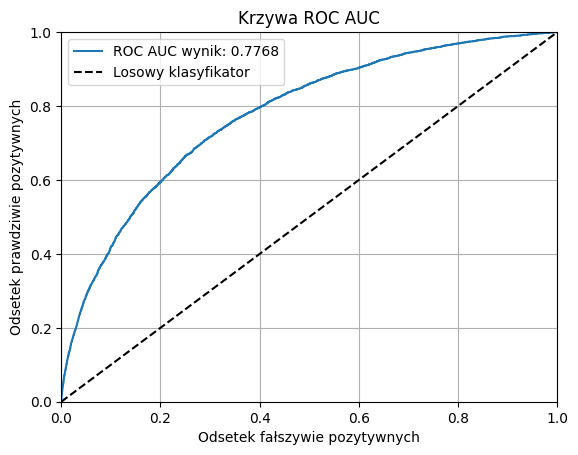

In [15]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC AUC wynik: {val_auc:.4f}')
plt.plot([0,1], [0, 1], 'k--', label='Losowy klasyfikator')
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.axis([0, 1, 0, 1])
plt.title('Krzywa ROC AUC')
plt.legend()
plt.grid()
plt.show()

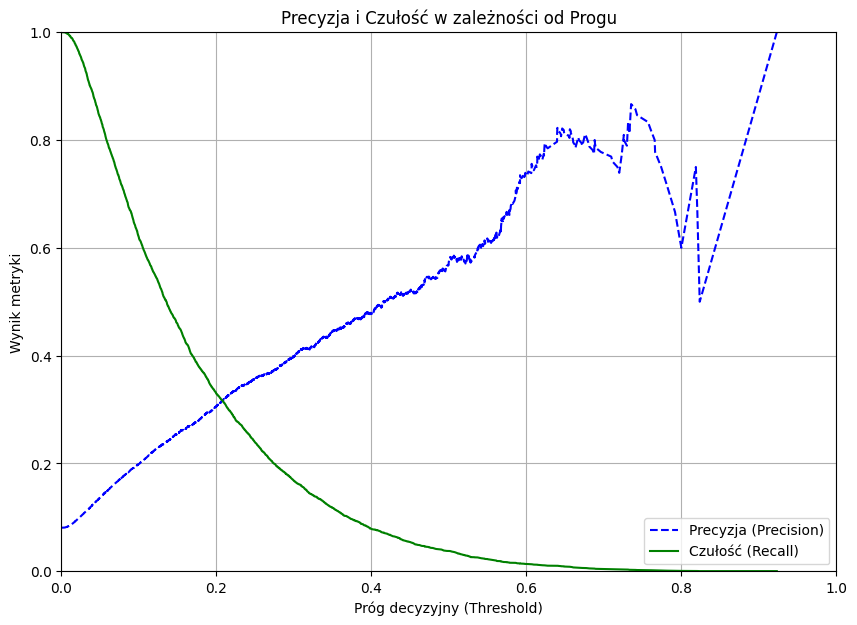

In [16]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], "b--", label="Precyzja (Precision)") 
plt.plot(thresholds, recall[:-1], "g-", label="Czułość (Recall)")      
plt.xlabel("Próg decyzyjny (Threshold)")
plt.ylabel("Wynik metryki")
plt.title("Precyzja i Czułość w zależności od Progu")
plt.grid(True)
plt.legend()
plt.axis([0, 1, 0, 1])
plt.show()

In [18]:
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

mlflow.set_tracking_uri('file:./mlruns')
experiment_name = 'Home_Credit_XGB_Optuna'
mlflow.set_experiment(experiment_name)

mlflow_callback = MLflowCallback(
   tracking_uri=mlflow.get_tracking_uri(),
   metric_name='roc_auc',
   create_experiment=False
)

def objective(trial):
    params = {
        'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'random_state': 42,
        'n_jobs': 1,
        'tree_method': 'hist', 
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15), 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10), 
    }

    model = XGBClassifier(**params)
    model_pipeline = Pipeline([
        ('main_pipeline', main_pipeline),
        ('model', model)
    ])
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    return np.mean(scores)

study_name = 'xgb-home-credit-tuning'
storage_name=f'sqlite:///{study_name}.db'
if os.path.exists(f'{study_name}.db'):
    os.remove(f'{study_name}.db')

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=False,
    direction='maximize'
)

study.optimize(objective, n_trials=50, n_jobs=1, callbacks=[mlflow_callback])
print(f'\n Best score XGB(CV): {study.best_value:.4f}')

best_params = study.best_params
best_params['n_jobs'] = -1
best_params['tree_method'] = 'hist'
best_params['objective'] = 'binary:logistic'

print('Fitting and saving best XGB model:')

with mlflow.start_run(run_name='Best_XGB_Optuna') as run:
    mlflow.log_params(best_params)
    mlflow.log_metric('final_cv_auc', study.best_value)

    final_xgb = XGBClassifier(**best_params)
    final_pipeline_xgb = Pipeline([
        ('main_pipeline', main_pipeline),
        ('final_xgb', final_xgb)
    ])
    final_pipeline_xgb.fit(X_train, y_train)
    mlflow.sklearn.log_model(final_pipeline_xgb, artifact_path='model')
    run_id = run.info.run_id
    print('Model ready and save in mlflow')
    print(f'Run ID: {run_id}')

2025/12/10 19:40:14 INFO mlflow.tracking.fluent: Experiment with name 'Home_Credit_XGB_Optuna' does not exist. Creating a new experiment.
C:\Users\szymo\AppData\Local\Temp\ipykernel_19700\1504975380.py:9: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2025-12-10 19:40:14,960] A new study created in RDB with name: xgb-home-credit-tuning
[I 2025-12-10 19:41:25,304] Trial 0 finished with value: 0.7659926210333378 and parameters: {'n_estimators': 500, 'learning_rate': 0.10154995880347471, 'max_depth': 7, 'min_child_weight': 15, 'subsample': 0.8342983699405648, 'colsample_bytree': 0.6177576184149264, 'gamma': 0.5782832898674373, 'reg_alpha': 8.544731715328219, 'reg_lambda': 7.8867397026371915}. Best is trial 0 with value: 0.7659926210333378.
[I 2025-12-10 19:42:22,986] Trial 1 finished with value: 0.7710434146775583 and parameters: {'n_estimators': 900, 'learning_rate': 0.11155523377


 Best score XGB(CV): 0.7745
Fitting and saving best XGB model:


2025/12/10 21:29:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model ready and save in mlflow
Run ID: c1880e3477604953b975b753d75c188b


In [21]:
run_id = 'c1880e3477604953b975b753d75c188b'
print(f'Reading model from: {run_id}')
model_uri = f'runs:/{run_id}/model'
loaded_model = mlflow.sklearn.load_model(model_uri)

y_pred_proba_xgb = loaded_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred_proba_xgb)
print(f'AUC score on test data: {val_auc}')

Reading model from: c1880e3477604953b975b753d75c188b


AUC score on test data: 0.7791619122245831


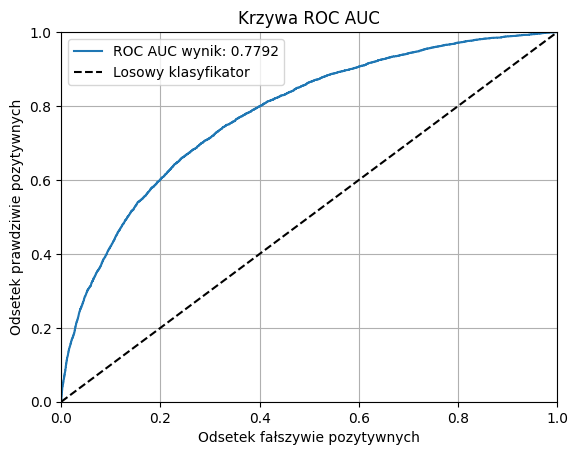

In [22]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_xgb)

plt.plot(fpr, tpr, label=f'ROC AUC wynik: {val_auc:.4f}')
plt.plot([0,1], [0, 1], 'k--', label='Losowy klasyfikator')
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.axis([0, 1, 0, 1])
plt.title('Krzywa ROC AUC')
plt.legend()
plt.grid()
plt.show()

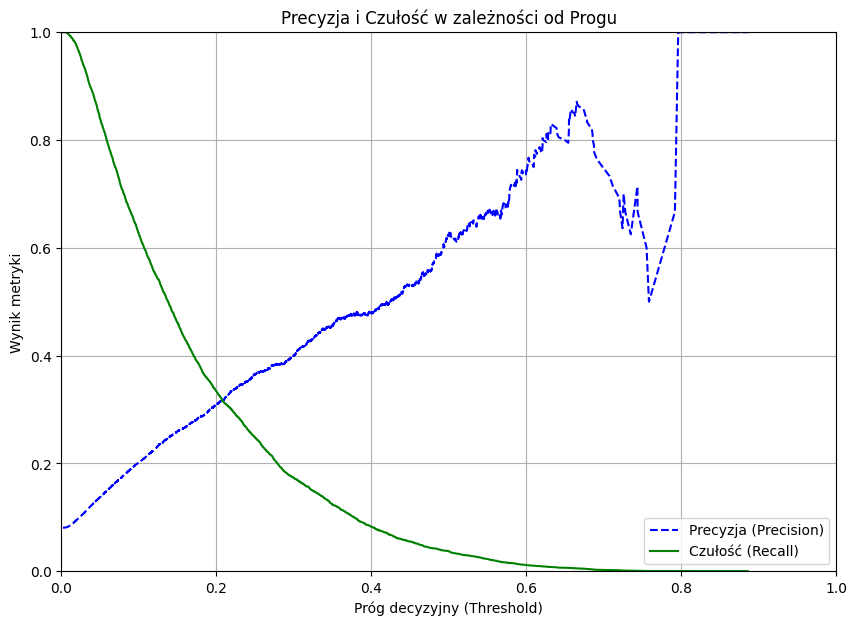

In [23]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_val, y_pred_proba_xgb)

plt.figure(figsize=(10, 7))
plt.plot(thresholds_xgb, precision_xgb[:-1], "b--", label="Precyzja (Precision)") 
plt.plot(thresholds_xgb, recall_xgb[:-1], "g-", label="Czułość (Recall)")      
plt.xlabel("Próg decyzyjny (Threshold)")
plt.ylabel("Wynik metryki")
plt.title("Precyzja i Czułość w zależności od Progu")
plt.grid(True)
plt.legend()
plt.axis([0, 1, 0, 1])
plt.show()

In [10]:
run_id_lgbm = 'c30e34d6964e4131956abe983534b0b7'
print(f'Reading model from: {run_id_lgbm}')
model_uri_lgbm = f'runs:/{run_id_lgbm}/model'
best_model_lgbm = mlflow.sklearn.load_model(model_uri_lgbm)

run_id_xgb = 'c1880e3477604953b975b753d75c188b'
print(f'Reading model from: {run_id_xgb}')
model_uri_xgb = f'runs:/{run_id_xgb}/model'
best_model_xgb = mlflow.sklearn.load_model(model_uri_xgb)


voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', best_model_lgbm),
        ('xgb', best_model_xgb)
    ],
    voting='soft',
    weights=[0.4, 0.6],
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)

Reading model from: c30e34d6964e4131956abe983534b0b7


Reading model from: c1880e3477604953b975b753d75c188b


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lgbm', ...), ('xgb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.","[0.4, 0.6]"
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",-1
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are

In [11]:
y_pred_proba_vot = voting_clf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred_proba_vot)
print(f'AUC score on test data: {val_auc}')

c:\Users\szymo\Desktop\hhh\home_credit_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC score on test data: 0.778604082623431


<Figure size 800x600 with 0 Axes>

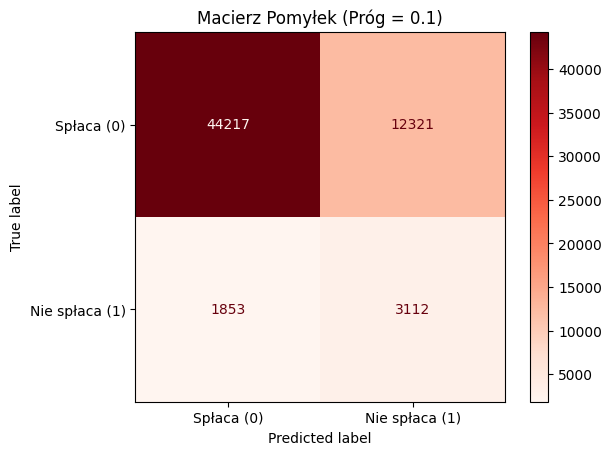


ANALIZA DLA PROGU 0.1:
Czułość (Recall):   62.68%
Precyzja (Precision): 20.16%
FN (Przepuszczeni oszuści - Największe ryzyko): 1853
FP (Odrzuceni uczciwi - Utracony zarobek):     12321


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

THRESHOLD = 0.1  

y_pred_proba = best_model_xgb.predict_proba(X_val)[:, 1]

y_pred_custom = (y_pred_proba >= THRESHOLD).astype(int)

cm = confusion_matrix(y_val, y_pred_custom)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Spłaca (0)', 'Nie spłaca (1)'])
disp.plot(cmap='Reds', values_format='d') 
plt.title(f'Macierz Pomyłek (Próg = {THRESHOLD})')
plt.grid(False)
plt.show()

tn, fp, fn, tp = cm.ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)

print(f"\nANALIZA DLA PROGU {THRESHOLD}:")
print(f"Czułość (Recall):   {recall:.2%}")
print(f"Precyzja (Precision): {precision:.2%}")
print(f"FN (Przepuszczeni oszuści - Największe ryzyko): {fn}")
print(f"FP (Odrzuceni uczciwi - Utracony zarobek):     {fp}")

In [34]:
import pandas as pd
from sklearn.metrics import confusion_matrix

y_pred_proba = best_model_xgb.predict_proba(X_val)[:, 1]

thresholds = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12]

print(f"{'Próg':<6} | {'Recall':<8} | {'Precision':<10} | {'FN (Ryzyko)':<12} | {'FP (Utracony zarobek)':<20}")
print("-" * 75)

for thresh in thresholds:
    y_pred_custom = (y_pred_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_custom).ravel()
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    
    print(f"{thresh:<6.2f} | {recall:<8.1%} | {precision:<10.1%} | {fn:<12} | {fp:<20}")

Próg   | Recall   | Precision  | FN (Ryzyko)  | FP (Utracony zarobek)
---------------------------------------------------------------------------
0.05   | 83.9%    | 13.7%      | 797          | 26241               
0.06   | 79.4%    | 15.1%      | 1025         | 22142               
0.07   | 74.9%    | 16.5%      | 1246         | 18883               
0.08   | 70.2%    | 17.7%      | 1479         | 16195               
0.09   | 66.5%    | 19.0%      | 1664         | 14070               
0.10   | 62.7%    | 20.2%      | 1853         | 12321               
0.12   | 55.5%    | 22.5%      | 2208         | 9484                


###  Threshold Calibration & Business Impact

Since the dataset is highly imbalanced, the default classification threshold of `0.5` is suboptimal. I analyzed the trade-off between **Recall** (Safety) and **Precision** (Efficiency) across different thresholds to align the model with business goals.

**Key Observations from the Table:**

1.  **Conservative Strategy (Threshold 0.05 - 0.06):**
    * **High Recall (~80-84%):** We detect the vast majority of potential defaulters.
    * **Cost:** High number of False Positives (over 20k). This means rejecting many solvent clients (lost revenue) to ensure maximum safety.
    * *Use Case:* Suitable for a bank with a very low risk appetite during an economic crisis.

2.  **Aggressive Strategy (Threshold > 0.10):**
    * **Higher Precision:** We reject fewer good customers (FP drops to ~12k), maximizing market share.
    * **Risk:** False Negatives increase significantly (Recall drops below 63%). We fail to spot over 1800 defaulters.
    * *Use Case:* Suitable for a "challenger bank" focused on rapid growth and acquiring market share.

**Strategic Recommendation:**
A balanced threshold around **0.08** appears optimal for a standard scenario. It maintains a solid **Recall of ~70%** (catching most defaults) while reducing the "lost opportunity" (FP) by nearly **40%** compared to the 0.05 threshold.

<Figure size 800x600 with 0 Axes>

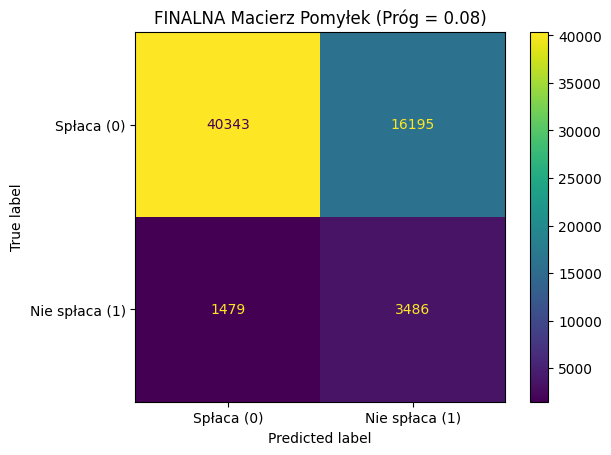


 RAPORT KOŃCOWY (XGBoost @ Threshold 0.08):
Skuteczność wykrywania oszustów (Recall): 70.21%
Precyzja odmów (Precision):             17.71%
Skuteczność wykrywania uczciwych (Spec.): 71.36%
------------------------------------------------------------
Liczba udzielonych dobrych kredytów: 40343
Liczba unikniętych strat (wykryci oszuści): 3486
Liczba utraconych szans (odrzuceni uczciwi): 16195


In [37]:

FINAL_THRESHOLD = 0.08 

y_pred_proba = best_model_xgb.predict_proba(X_val)[:, 1]
y_pred_final = (y_pred_proba >= FINAL_THRESHOLD).astype(int)

cm = confusion_matrix(y_val, y_pred_final)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Spłaca (0)', 'Nie spłaca (1)'])
disp.plot( values_format='d') 
plt.title(f'FINALNA Macierz Pomyłek (Próg = {FINAL_THRESHOLD})')
plt.grid(False)
plt.show()

print(f"\n RAPORT KOŃCOWY (XGBoost @ Threshold {FINAL_THRESHOLD}):")
print("="*60)
tn, fp, fn, tp = cm.ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
specificity = tn / (tn + fp) 

print(f"Skuteczność wykrywania oszustów (Recall): {recall:.2%}")
print(f"Precyzja odmów (Precision):             {precision:.2%}")
print(f"Skuteczność wykrywania uczciwych (Spec.): {specificity:.2%}")
print("-" * 60)
print(f"Liczba udzielonych dobrych kredytów: {tn}")
print(f"Liczba unikniętych strat (wykryci oszuści): {tp}")
print(f"Liczba utraconych szans (odrzuceni uczciwi): {fp}")

In [38]:
preprocessor = best_model_xgb.named_steps['main_pipeline']
xgb_model_raw = best_model_xgb.named_steps['final_xgb']

X_val_processed = preprocessor.transform(X_val)

feature_names = preprocessor.get_feature_names_out()

X_val_transformed_df = pd.DataFrame(
    X_val_processed,
    columns=feature_names
)

In [39]:
explainer = shap.TreeExplainer(xgb_model_raw)
shap_values = explainer(X_val_transformed_df)

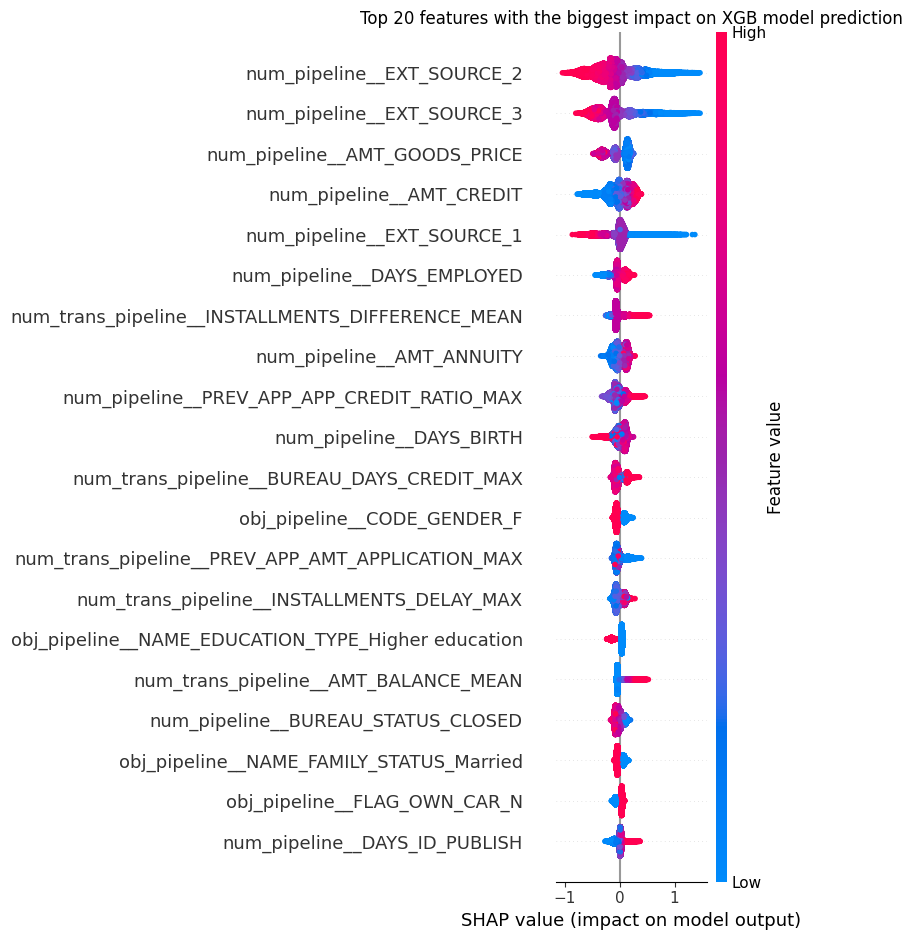

In [40]:
plt.figure()
shap.summary_plot(shap_values, X_val_transformed_df, max_display=20, show=False)
plt.title('Top 20 features with the biggest impact on XGB model prediction')
plt.tight_layout()
plt.show()

**Key Findings:**
1.  **Dominance of `EXT_SOURCE`:**
    * These features are at the top, confirming they are the strongest predictors.
    * **Direction:** High values (Red dots) are located on the left (Negative SHAP).
    * *Insight:* A high external credit score significantly **reduces** the probability of default.

2.  **Wealth Effect (`AMT_GOODS_PRICE`):**
    * High values (Red) are generally associated with negative SHAP values.
    * *Insight:* Clients purchasing more expensive goods tend to be safer borrowers.

3.  **Demographics (`DAYS_BIRTH`):**
    * "High" values (closer to 0, meaning younger people) push the risk up (Right side).
    * *Insight:* Youth is a risk factor, while older age stabilizes the credit score.

**Conclusion:**
The model relies on logical, justifiable patterns (Credit History, Wealth, Stability) rather than noise, making it compliant with regulatory requirements for transparency.